In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.3.0'

In [9]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [10]:
type(train_images)

numpy.ndarray

In [11]:
train_images.dtype, train_images.shape

(dtype('uint8'), (50000, 32, 32, 3))

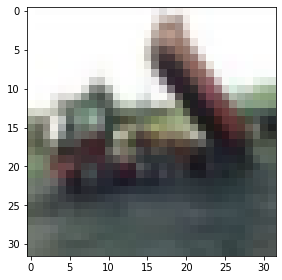

In [17]:
imshow(train_images[2])

In [13]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

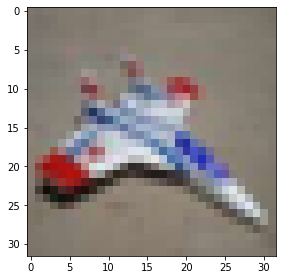

In [14]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[30]))

In [15]:
type(train_img_f32)

numpy.ndarray

In [7]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((4, 4, 256)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
]
)

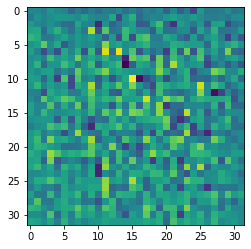

In [9]:
noise = tf.random.normal([BATCH_SIZE, latent_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])#, cmap='gray')

In [10]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32,32, 3)),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Flatten(),
   Dense(1)]
)

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [12]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [15]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap= None)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


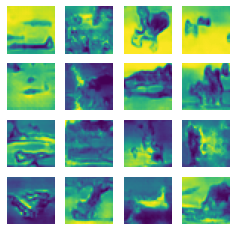

0 [2.7229118  0.41230825] 14.61202073097229


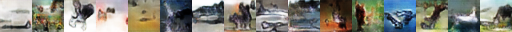

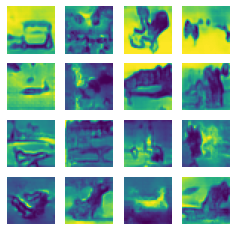

1 [2.6589334  0.39212686] 15.266852140426636


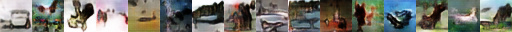

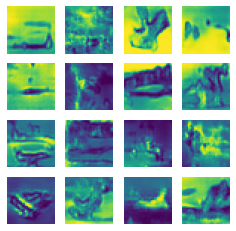

2 [2.7039826 0.3960322] 14.331528902053833


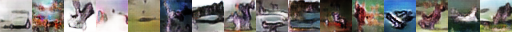

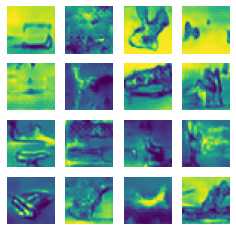

3 [2.7185097  0.40763026] 15.45264196395874


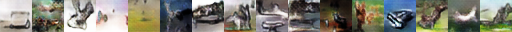

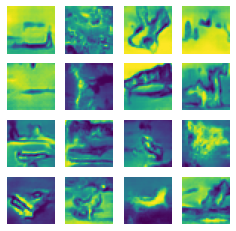

4 [2.7630692 0.3942465] 15.418081283569336


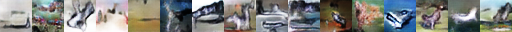

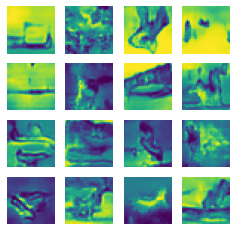

5 [2.6795292  0.40211028] 15.361849546432495


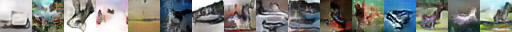

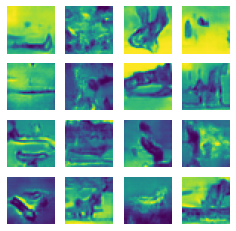

6 [2.7122717  0.41055936] 15.489789724349976


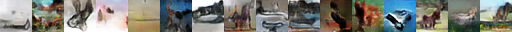

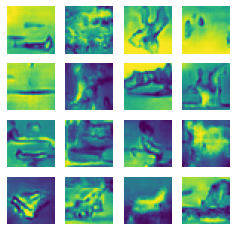

7 [2.7250118  0.39767307] 15.263686656951904


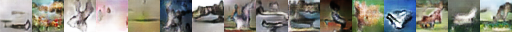

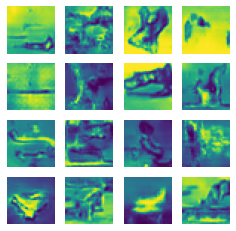

8 [2.7192855  0.38865778] 14.332923412322998


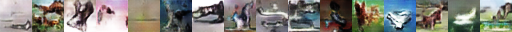

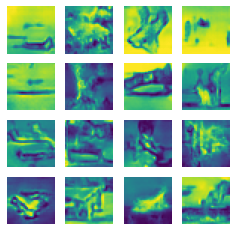

9 [2.798777  0.3898285] 15.595524787902832


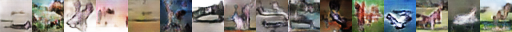

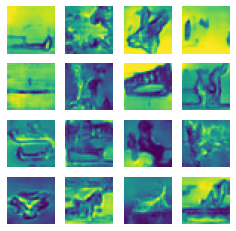

10 [2.7412615 0.3893069] 15.528830766677856


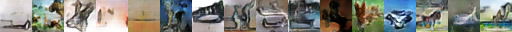

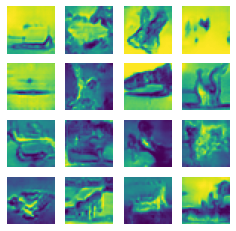

11 [2.852221  0.3653478] 14.465683698654175


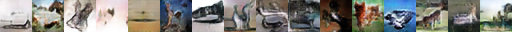

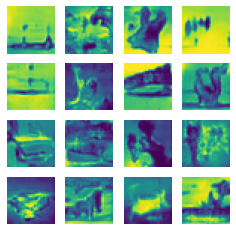

12 [2.839887  0.4180088] 15.685490131378174


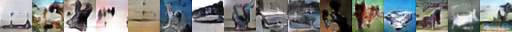

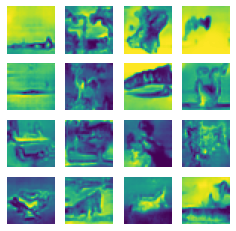

13 [2.7753575  0.38032463] 15.47102952003479


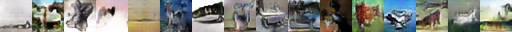

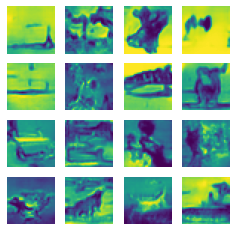

14 [2.8588386  0.37465206] 14.32058572769165


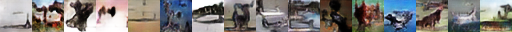

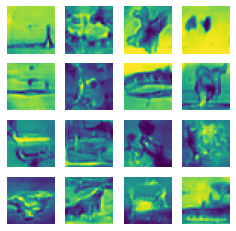

15 [2.8584425  0.37770376] 15.521510601043701


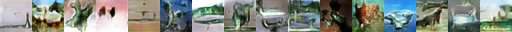

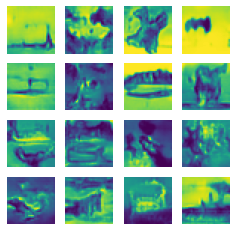

16 [2.8599586  0.36740133] 15.341519832611084


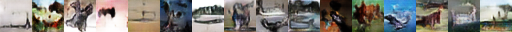

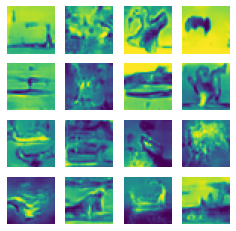

17 [2.8900313  0.37726822] 14.392040729522705


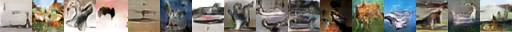

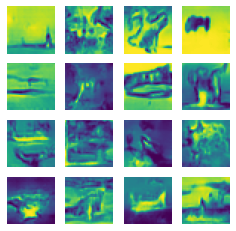

18 [2.835989   0.35227713] 15.498849630355835


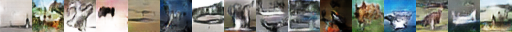

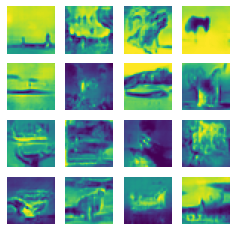

19 [2.933939   0.36592302] 15.326395750045776


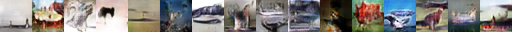

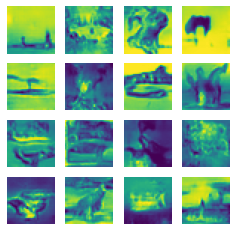

20 [2.9628856 0.3350712] 14.366349458694458


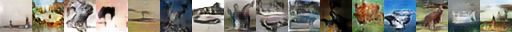

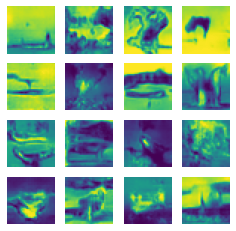

21 [2.9659767  0.34134635] 15.500372409820557


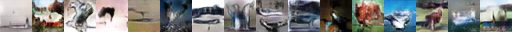

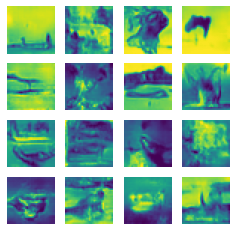

22 [2.9977348  0.34515303] 15.426584959030151


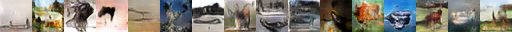

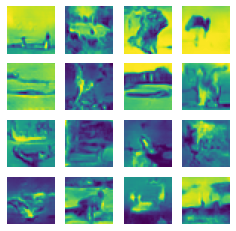

23 [2.9933677  0.37121126] 15.395028352737427


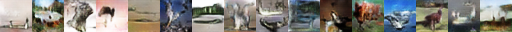

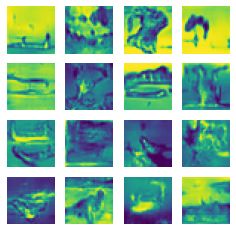

24 [2.9740527  0.34072483] 15.510361909866333


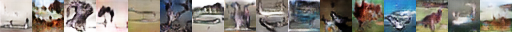

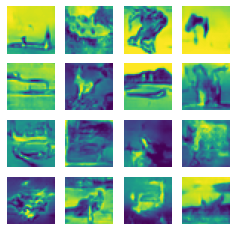

25 [3.0320714  0.34793463] 15.351670026779175


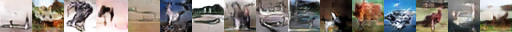

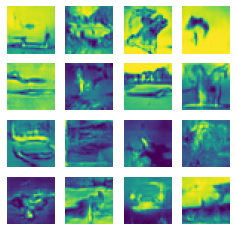

26 [3.018623   0.33370844] 14.35847282409668


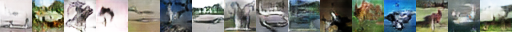

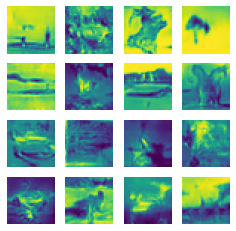

27 [2.995362   0.35544094] 15.46522855758667


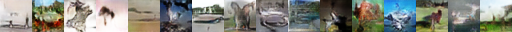

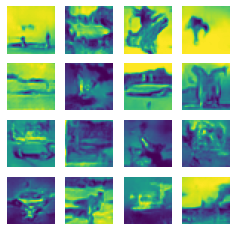

28 [3.0659351 0.3275262] 15.418298721313477


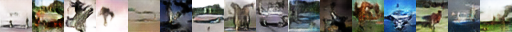

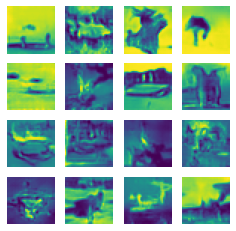

29 [3.1256099  0.33372298] 15.381864070892334


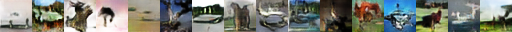

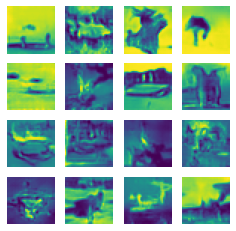

In [23]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))

  generate_and_save_images(generator,
                             epoch + 1,
                             random_vector_for_generation)
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  
  display(PIL.Image.fromarray(fake_concat))
  
generate_and_save_images(generator,
                             epoch ,
                             random_vector_for_generation) 